In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ETL Urbania 2

In [2]:
df = pd.read_csv('./dataset/01_etl_urbania.csv')
df.rename(columns={'price': 'price_USD', 'area': 'area_m2', 'total_bath': 'bath', 'total_bed': 'bed'}, inplace=True)
print(df.shape)
df.head(4)

(16760, 14)


,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",NaN,https://urbania.pe/inmueble/proyecto/ememvein-...
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",NaN,https://urbania.pe/inmueble/proyecto/ememvein-...
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",NaN,https://urbania.pe/inmueble/proyecto/ememvein-...
3,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",157815.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",NaN,https://urbania.pe/inmueble/proyecto/ememvein-...


## Property Type

In [3]:
df = df[~(df['property_type'].isna())]
df['description'].fillna('', inplace=True)
df['general_features'].fillna('{}', inplace=True)
df['services'].fillna('{}', inplace=True)
df['ambience'].fillna('{}', inplace=True)
print(df.shape)
df[['general_features', 'services', 'ambience']].isna().sum()

(16759, 14)


general_features    0
services            0
ambience            0
dtype: int64

## General Features

The 'general_features' field contains multiple features houses can have, for example, being near to parks, supermarkets, pricipal streets, schools and so forth.

Let's see what is the most common features

In [4]:
general_features = df['general_features'].str.strip('{}').str.split(',').to_list()
general_features = [x.strip('""') for y in general_features for x in y]
genereal_counter = Counter(general_features)
genereal_counter = dict(sorted(genereal_counter.items(), key=lambda item: item[1], reverse=True))

for element, count in genereal_counter.items():
    if count <= df.shape[0]*0.3:
        break
    print(f"{element}: {count}")

Número de pisos: 10092
Cerca a colegios: 6350
Centros Comerciales Cercanos: 6205
Reposteros en cocina: 5301
Cocina: 5130


In [41]:
Counter(general_features)

Counter({'Número de pisos': 10092,
         'Cerca a colegios': 6350,
         'Centros Comerciales Cercanos': 6205,
         'Reposteros en cocina': 5301,
         'Cocina': 5130,
         'Ascensor': 4979,
         'Terraza': 4717,
         'Intercomunicador': 4700,
         'Closet': 4660,
         'Cuartos de servicio': 4592,
         'Cerca a Parque (a menos de 2 cdras)': 4445,
         'Baño de servicio': 4328,
         'Seguridad': 4104,
         'Mascotas': 4062,
         'Piso en el que se encuentra': 3731,
         'Walk in closet': 3161,
         'Recepción': 3152,
         'Tipo de Cochera': 3053,
         'Av. acceso asfaltada': 3045,
         'Jardín(es)': 2802,
         'Vista a la Ciudad': 2744,
         'Piscina': 2346,
         'Acabados de Lujo': 1829,
         'Número de departamentos': 1693,
         'Caseta de guardia': 1551,
         '': 1480,
         'Sistema contra incendios': 1431,
         'Frente a Parque': 1349,
         'Vista Parque': 1241,
         'Dup

In [44]:
mask = df['general_features'].apply(lambda x: 'Número de locales comerciales' in x)
df.loc[mask]

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks,laundry_Area,private_Security
4716,Venta de Edificio 5 Pisos,"Bolivar 18, Almirante Miguel GrauParamonga, Ba...",107000.0,110,10.0,10.0,Casa,Ubicación estratégica: A una cuadra de la Plaz...,0,2013,"{""Vista a la Ciudad"",Terraza,""Entrada independ...","{""Uso Comercial"",Parrilla,""Area de lavandería""...",{},https://urbania.pe/inmueble/clasificado/veclca...,1,1,1,1,0
5962,"Casa en Venta en La Urb. Risso, Santa Anita","Calle Francia, San Jose De MangomarcaSanta Ani...",320000.0,152,8.0,14.0,Casa,"Doors te presenta esta oportunidad de negocio,...",8,2008,"{""Baño de servicio"",Terraza,""Niveles construid...","{""Uso Profesional"",""Guardianía/Seguridad priva...","{Patio,""Baño Propio"",Bodega(s),""Ingreso indepe...",https://urbania.pe/inmueble/clasificado/veclot...,1,1,0,1,1
7066,"Casa en Venta en La Urb. Risso, Santa Anita","Calle Francia, San Jose De MangomarcaSanta Ani...",320000.0,152,8.0,14.0,Casa,"Doors te presenta esta oportunidad de negocio,...",8,2008,"{""Baño de servicio"",Terraza,""Niveles construid...","{""Uso Profesional"",""Guardianía/Seguridad priva...","{Patio,""Baño Propio"",Bodega(s),""Ingreso indepe...",https://urbania.pe/inmueble/clasificado/veclot...,1,1,0,1,1
13700,Vende Local en Av 200 Millas Santa Luisa de Oq...,"Millas , Cercado del Callao, Callao, CallaoCa...",155000.0,391,6.0,2.0,Casa,Distrito: CALLAO Límite con SMP <br>Dirección:...,2,2018,"{""Tipo de piso"",""Sistema contra incendios"",""Ni...","{""Uso Profesional"",""Posee luminarias""}","{Oficinas,Patio,""Hall de ingreso"",""Ingreso ind...",https://urbania.pe/inmueble/clasificado/veclca...,1,1,0,0,0


In [5]:
df['near_CC'] = np.zeros(df.shape[0], dtype=int)
df['near_School'] = np.zeros(df.shape[0], dtype=int)
df['near_Parks'] = np.zeros(df.shape[0], dtype=int)

### Near to Malls

Let's create a new column that says whether or not the house is nearby malls, depicted by 0 and 1.

In [6]:
mask = df['general_features'].apply(lambda x: 'Centros Comerciales Cercanos' in x)
df.loc[mask, 'near_CC'] = np.ones(shape=df[mask].shape[0], dtype=int)
df.head(2)

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,0,0,0
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,0,0,0


On the other hand, maybe that info could be into the description. Let's check out

In [7]:
pattern = 'mall|comercial|mercado'
id_mall = df.loc[df['near_CC'] == 0]['description'].apply(lambda x: x.lower()).str.extract(f'({pattern})').dropna().index
df.loc[id_mall, 'near_CC'] = np.ones(shape=df.loc[id_mall].shape[0], dtype=int)
df.head(2)

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0


In [8]:
print('0 :', df[df['near_CC'] == 0].shape[0])
print('1 :', df[df['near_CC'] == 1].shape[0])


0 : 6647
1 : 10112


### Near to Schools

In [9]:
mask = df['general_features'].apply(lambda x: 'Cerca a colegios' in x)
df.loc[mask, 'near_School'] = np.ones(shape=df[mask].shape[0], dtype=int)
df.head(2)

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0


In [10]:
pattern = 'colegio|escuela|educativ'
id_school = df.loc[df['near_School'] == 0]['description'].apply(lambda x: x.lower()).str.extract(f'({pattern})').dropna().index
df.loc[id_school, 'near_School'] = np.ones(shape=df.loc[id_school].shape[0], dtype=int)
print('0 :', df[df['near_School'] == 0].shape[0])
print('1 :', df[df['near_School'] == 1].shape[0])

0 : 8043
1 : 8716


### Near to Parks

Into this field we take into account the parks, green areas, garden, see, pool and gyms.

In [11]:
pattern = 'parque|areas verdes|cancha|gimnasio|jard|piscina|playa|mar'
id_park = df['description'].str.extract(f'({pattern})').dropna().index
df.loc[id_park, 'near_Parks'] = np.ones(shape=df.loc[id_park].shape[0], dtype=int)
print('0 :', df[df['near_Parks'] == 0].shape[0])
print('1 :', df[df['near_Parks'] == 1].shape[0])

0 : 6947
1 : 9812


In [12]:
df.head()

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1
3,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",157815.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1
4,Proyecto inmobilario en venta en Jirón Batalló...,"Jirón Batallón Callao Norte , Santa TeresaSan...",239998.4,110,3.0,3.0,Departamento,Vive exclusivo en Surco | Vive en Libitum | En...,0,2023,"{""No. de edificios que conforman el proyecto"",...",{},{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0


# Services

In [13]:
services = df['services'].str.strip('{}').str.split(',').to_list()
services = [x.strip('""') for y in services for x in y]
service_counter = Counter(services)
service_counter = dict(sorted(service_counter.items(), key=lambda item: item[1], reverse=True))

for element, count in service_counter.items():
    if count <= df.shape[0]*0.2:
        break
    print(f"{element}: {count}")

Area de lavandería: 7611
Servicios básicos (agua/luz): 6808
: 5227
Guardianía/Seguridad privada: 4676
Parrilla: 4059
Areas verdes: 3633


From this fields let's take into account 'Area de lavanderia' and 'Seguridad privada'

In [14]:
df['laundry_Area'] = np.zeros(df.shape[0], dtype=int)
df['private_Security'] = np.zeros(df.shape[0], dtype=int)
df.shape

(16759, 19)

### Laudry Area & Private Security

In [15]:
mask = df['services'].apply(lambda x: 'Area de lavandería' in x)
df.loc[mask, 'laundry_Area'] = np.ones(shape=df[mask].shape[0], dtype=int)
print('Laundry')
print('0 :', df[df['laundry_Area'] == 0].shape[0])
print('1 :', df[df['laundry_Area'] == 1].shape[0])

mask = df['services'].apply(lambda x: 'Seguridad privada' in x)
df.loc[mask, 'private_Security'] = np.ones(shape=df[mask].shape[0], dtype=int)
print('Security')
print('0 :', df[df['private_Security'] == 0].shape[0])
print('1 :', df[df['private_Security'] == 1].shape[0])

Laundry
0 : 9148
1 : 7611
Security
0 : 12083
1 : 4676


Digging into the descriptions

In [16]:
pattern = 'lavander|terraza'
id_laundry = df.loc[df['laundry_Area'] == 0, 'description'].apply(lambda x: x.lower()).str.extract(f'({pattern})').dropna().index
df.loc[id_laundry, 'laundry_Area'] = np.ones(shape=df.loc[id_laundry].shape[0], dtype=int)
print('Laundry')
print('0 :', df[df['laundry_Area'] == 0].shape[0])
print('1 :', df[df['laundry_Area'] == 1].shape[0])

pattern = 'seguridad|guard'
id_security = df.loc[df['private_Security'] == 0, 'description'].apply(lambda x: x.lower()).str.extract(f'({pattern})').dropna().index
df.loc[id_security, 'private_Security'] = np.ones(shape=df.loc[id_security].shape[0], dtype=int)
print('Security')
print('0 :', df[df['private_Security'] == 0].shape[0])
print('1 :', df[df['private_Security'] == 1].shape[0])

Laundry
0 : 3619
1 : 13140
Security
0 : 9605
1 : 7154


# Ambience

In [17]:
ambience = df['ambience'].str.strip('{}').str.split(',').to_list()
ambience = [x.strip('""') for y in ambience for x in y]
ambience_counter = Counter(ambience)
ambience_counter = dict(sorted(ambience_counter.items(), key=lambda item: item[1], reverse=True))

for element, count in ambience_counter.items():
    if count <= df.shape[0]*0.2:
        break
    print(f"{element}: {count}")

: 10043
Dormitorio principal con baño: 4422


Due to the few data about ambience we going to ignore this column

In [18]:
df.head()

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks,laundry_Area,private_Security
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1,0,0
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277.0,45,2.0,3.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1,0,0
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1,0,0
3,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",157815.0,60,2.0,2.0,Departamento,Mozz se deriva de la palabra en italiano mozio...,1,2023,"{""Promotion Description"",""Promotion Title"",""Nú...","{""Areas verdes""}",{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,1,0,0
4,Proyecto inmobilario en venta en Jirón Batalló...,"Jirón Batallón Callao Norte , Santa TeresaSan...",239998.4,110,3.0,3.0,Departamento,Vive exclusivo en Surco | Vive en Libitum | En...,0,2023,"{""No. de edificios que conforman el proyecto"",...",{},{},https://urbania.pe/inmueble/proyecto/ememvein-...,1,0,0,0,0


## Fixing Outliers

Now we need to analyse the distribution on numerical data, understand its outliers and decide how to deal it with

In [19]:
df.columns

Index(['title', 'address', 'price_USD', 'area_m2', 'bath', 'bed',
       'property_type', 'description', 'parking', 'antiquity',
       'general_features', 'services', 'ambience', 'property_url', 'near_CC',
       'near_School', 'near_Parks', 'laundry_Area', 'private_Security'],
      dtype='object')

In [20]:
df_num = df[['price_USD', 'area_m2', 'bath', 'bed', 'parking', 'antiquity', 'near_CC',
            'near_School', 'near_Parks', 'laundry_Area', 'private_Security']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16759 entries, 0 to 16759
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_USD         16759 non-null  float64
 1   area_m2           16759 non-null  int64  
 2   bath              16759 non-null  float64
 3   bed               16759 non-null  float64
 4   parking           16759 non-null  int64  
 5   antiquity         16759 non-null  int64  
 6   near_CC           16759 non-null  int64  
 7   near_School       16759 non-null  int64  
 8   near_Parks        16759 non-null  int64  
 9   laundry_Area      16759 non-null  int64  
 10  private_Security  16759 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.0 MB


In [21]:
df_num.describe()

,price_USD,area_m2,bath,bed,parking,antiquity,near_CC,near_School,near_Parks,laundry_Area,private_Security
count,1.675900e+04,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000,16759.000000
mean,5.284894e+05,247.114327,2.703801,3.353422,1.092010,2011.724506,0.603377,0.520079,0.585476,0.784056,0.426875
std,1.443964e+07,1710.924681,1.562817,1.920513,1.781576,14.253872,0.489211,0.499612,0.492654,0.411488,0.494639
min,3.000000e-01,1.000000,0.000000,1.000000,0.000000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.200000e+05,78.000000,2.000000,3.000000,0.000000,2007.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.934530e+05,120.000000,2.000000,3.000000,1.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,3.400000e+05,205.000000,3.000000,4.000000,2.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.250000e+09,142200.000000,77.000000,96.000000,85.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 640x480 with 0 Axes>

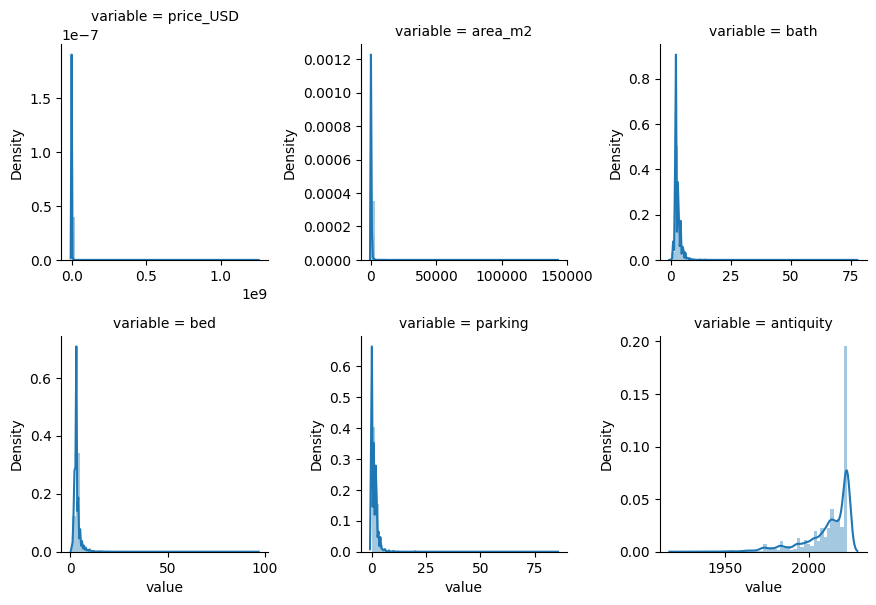

In [22]:
plt.figure()
f = pd.melt(df_num.iloc[:,:6], value_vars=df_num.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

Let's a lot of alarming outliers, especially for the fields of 'price_USD', 'area_m2', 'bath', 'bed'and 'parking'. Let's study them one by one

In [23]:
def outliers(column, df_outlier):
    Q1 = df_outlier[column].dropna().quantile(0.25)
    Q3 = df_outlier[column].dropna().quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    return lower_whisker, upper_whisker

In [24]:
def outliers(lower, upper, column, df_outlier):
    return df_outlier[((df_outlier[column] < lower)|(df_outlier[column] > upper))]

In [25]:
price_out = outliers

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16759 entries, 0 to 16759
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             16759 non-null  object 
 1   address           16759 non-null  object 
 2   price_USD         16759 non-null  float64
 3   area_m2           16759 non-null  int64  
 4   bath              16759 non-null  float64
 5   bed               16759 non-null  float64
 6   property_type     16759 non-null  object 
 7   description       16759 non-null  object 
 8   parking           16759 non-null  int64  
 9   antiquity         16759 non-null  int64  
 10  general_features  16759 non-null  object 
 11  services          16759 non-null  object 
 12  ambience          16759 non-null  object 
 13  property_url      16759 non-null  object 
 14  near_CC           16759 non-null  int64  
 15  near_School       16759 non-null  int64  
 16  near_Parks        16759 non-null  int64  
 17

In [40]:
pattern = 'avenida\s*principal.*'
df['description'].str.extract(f'({pattern})').dropna()

,0
2601,avenida principal Av. Bolivar. <br>Ubicado en ...
2609,avenida principal Av. Bolivar. <br>Ubicado en ...
2617,avenida principal Av. Bolivar. <br>Ubicado en ...
2627,avenida principal Av. Bolivar. <br>Ubicado en ...
2643,avenida principal Av. Bolivar. <br>Ubicado en ...
2658,avenida principal Av. Bolivar. <br>Ubicado en ...
2670,avenida principal Av. Bolivar. <br>Ubicado en ...
3116,"avenida principal, cerca a parques, a plaza ve..."
3554,avenida principales y a todo lo que necesitas....
3636,"avenida principal,&nbsp; Tupac Amaru . Cerca&n..."


In [29]:
df.property_type.value_counts()

property_type
Departamento     12612
Casa              3788
Casa de playa      254
Casa de campo      103
Habitación           2
Name: count, dtype: int64

### Price & Area

In [31]:
lower_price, upper_price = outliers('price_USD', df_num)
lower_area, upper_area = outliers('area_m2', df_num)
df[((df['price_USD'] < lower_price)|(df['price_USD'] > upper_price))&~((df['area_m2'] < lower_area)|(df['area_m2'] > upper_area))]

TypeError: outliers() missing 2 required positional arguments: 'column' and 'df_outlier'

<Figure size 640x480 with 0 Axes>

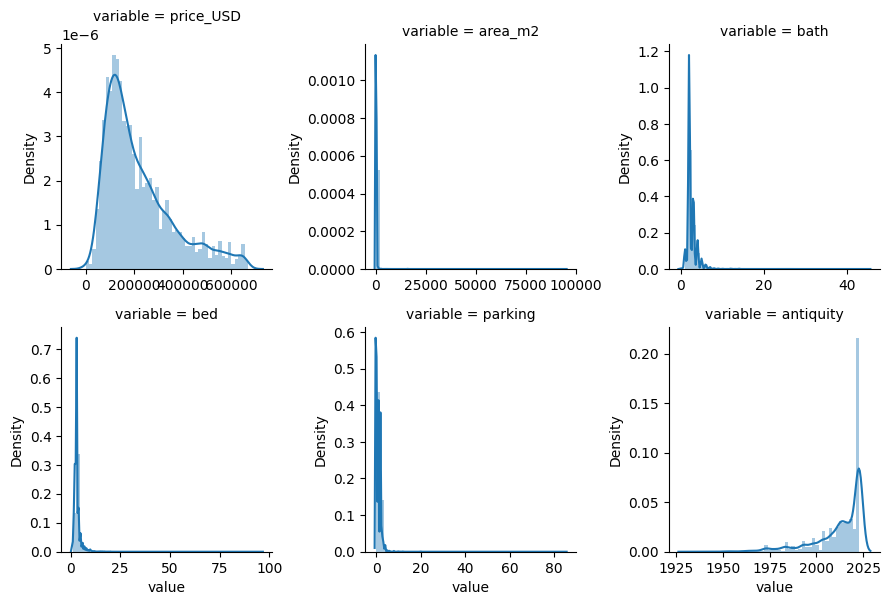

In [ ]:
plt.figure()
f = pd.melt(df_test.iloc[:,:6], value_vars=df_test.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

### Parking

In [ ]:
lower_parking, upper_parking = outliers('parking', df_num)
df[((df['parking'] < lower_parking)|(df['parking'] > upper_parking))]

,title,address,price_USD,area_m2,bath,bed,property_type,description,parking,antiquity,general_features,services,ambience,property_url,near_CC,near_School,near_Parks,laundry_Area,private_Security
79,"Lujosa Mansión con Vista Al Club El Golf, en L...","LA PLANICIE, La MolinaLima, Lima",4500000.0,3333,9.0,5.0,Casa,ÁREA DEL TERRENO <br>3333MT2 <br>ÁREA CONSTRUI...,10,2022,"{Jacuzzi,Jardín(es),Terraza,""Cuartos de servic...","{""Video vigilancia"",""Guardianía/Seguridad priv...",{Patio},https://urbania.pe/inmueble/clasificado/veclca...,0,0,1,1,1
241,"Casa1175 m&sup2; - Piscina, Terraza - Barandia...","Alameda Jose Leon Barandiaran 500, La Planicie...",1490000.0,1280,5.0,5.0,Casa,"Hermosa residencia de una sola planta, amplios...",6,2004,"{""Baño de servicio"",Jacuzzi,Jardín(es),Terraza...","{""Video vigilancia"",""Guardianía/Seguridad priv...",{},https://urbania.pe/inmueble/clasificado/veclca...,0,0,1,1,1
400,Gran Casa de 6 Dorm en Venta en Exclusivo Cond...,"Cerros de San Francisco surco, Santiago de Sur...",3112840.0,1198,6.0,6.0,Casa,ESPECTACULAR Casa en venta en Condominio Priva...,9,1984,"{""Vista a la Ciudad"",""Caseta de guardia"",Jardí...","{""Guardianía/Seguridad privada""}","{""Sala de estar"",Patio}",https://urbania.pe/inmueble/clasificado/veclca...,0,0,1,1,1
745,Se Vende Hermosa Casa en Pachacamac. Terreno 2...,"Urbanización San Fernando, Pachacamac, Pachaca...",530000.0,2500,4.0,7.0,Casa de campo,EN VENTA ESPECTACULAR CASA EN PACHACAMAC. MATE...,8,2010,"{""Baño de servicio"",Jardín(es),""Cuartos de ser...","{""Areas verdes"",Parrilla}","{Desagüe,Patio,""Comedor Diario"",""Parque Intern...",https://urbania.pe/inmueble/clasificado/veclcd...,1,0,0,0,0
905,Hermosa Casa Club en Venta – Surco,"monterrico chico, Santiago de SurcoLima, Lima",1999000.0,1310,5.0,4.0,Casa,AT: 1310 M2 <br><br>AC: 600 M2 <br><br>Hermosa...,6,2022,"{""Baño de servicio"",Jardín(es),Terraza,""Cuarto...","{Internet/Wifi,""Guardianía/Seguridad privada"",...","{""Dormitorio principal con baño""}",https://urbania.pe/inmueble/clasificado/veclca...,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16520,Casa Independiente en Venta en La Planicie C/b...,"EL HORIZONTE, La PlanicieLa Molina, Lima",1200000.0,1000,3.0,3.0,Casa,"HERMOSA CASA EN VENTA EN LA PLANICIE, CON BELL...",6,2012,"{""Baño de servicio"",Jardín(es),Terraza,""Cuarto...","{""Video vigilancia"",""Guardianía/Seguridad priv...","{""Sala de estar"",""Sala de entretenimiento"",""Co...",https://urbania.pe/inmueble/clasificado/veclca...,1,1,1,1,1
16527,Venta de Casa de Campo en Las Praderas de San ...,"km 75 Panamericana Sur, Sta.Cruz De FloresCañe...",460000.0,2234,3.0,5.0,Casa de campo,"Excelente oportunidad, se vende amplia y esple...",6,2020,"{""Baño de servicio"",""Caseta de guardia"",Jardín...","{Internet/Wifi,""Guardianía/Seguridad privada"",...","{Sauna,""Dormitorio principal con baño""}",https://urbania.pe/inmueble/clasificado/veclcd...,1,0,1,1,1
16556,Impresionante Casa con Vista Directa a Los Cam...,"Jose Leon Bariandaran, La PlanicieLa Molina, Lima",2900000.0,780,4.0,4.0,Casa,Impresionante residencia diseñada por el arqui...,6,2001,"{""Baño de servicio"",Jardín(es),Terraza,""Cuarto...","{""Línea blanca"",""Area de lavandería""}","{""Sala de estar"",Patio,""Comedor Diario"",""Dormi...",https://urbania.pe/inmueble/clasificado/veclca...,0,0,0,1,0
16606,Magnífica Vista Al Mar! Se Vende o Alquila Dep...,"Malecon Grau, ChorrillosChorrillos, Lima",1500000.0,600,4.0,5.0,Departamento,• ÁREA TOTAL: 600M2 <br>• ÁREA CONSTRUIDA: 400...,6,2018,"{""Baño de servicio"",Terraza,""Cuartos de servic...","{Internet/Wifi,""Video vigilancia"",""Guardianía/...","{""Sala de estar"",""Hall de ingreso"",""Ingreso in...",https://urbania.pe:443/inmueble/clasificado/ve...,0,0,1,1,1
